### Import modules

In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
from spks.event_aligned import population_peth
from chiCa.chiCa.visualization_utils import separate_axes
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', 100)

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [2]:
save_dir = Path('processed_data')
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = save_dir / animal / session
trial_ts = pd.read_pickle(data_dir / 'trial_ts.pkl')
spike_times_per_unit = np.load(data_dir / 'spike_times_per_unit.npy', allow_pickle=True)

In [5]:
def get_balanced_trials(trial_ts, require_both_stim_types=True):
    """Get balanced trials across conditions.
    
    Takes a DataFrame of trial data and returns a balanced subset with equal numbers
    of trials across conditions (correct/incorrect x left/right category).
    
    Args:
        trial_ts (pd.DataFrame): DataFrame containing trial data with columns:
            - trial_outcome: -1 (early withdrawal), 0 (incorrect) or 1 (correct)
            - trial_rate: Number of stimuli in trial (used to determine category)
            - category: 'left' (<12 Hz) or 'right' (>12 Hz)
            - response_side: 0 (left) or 1 (right)
            - movement_stims: array of movement stimulus timestamps 
            - stationary_stims: array of stationary stimulus timestamps
        require_both_stim_types (bool): If True, only include trials with both
            movement and stationary stimuli. Defaults to True.
            
    Returns:
        tuple:
            - pd.DataFrame: Balanced subset of trials with equal numbers across all
              conditions (left/right category x left/right response)
            - int: Number of trials per condition
            
    Notes:
        - Excludes trials with trial_rate=12 Hz (category boundary)
        - Excludes early withdrawals (trial_outcome=-1)
        - Uses random_state=42 for reproducible sampling
    """
    # Get valid trials (exclude outcome -1 and trial_rate 12)
    valid_trials = trial_ts[
        (trial_ts.trial_outcome.isin([0,1])) & 
        (trial_ts.trial_rate != 12)
    ]
    
    # Optionally require both stim types
    if require_both_stim_types:
        valid_trials = valid_trials[
            (valid_trials.movement_stims.apply(len) > 0) & 
            (valid_trials.stationary_stims.apply(len) > 0)
        ]
    
    # Find minimum number of trials across all conditions
    min_trials = min([
        len(valid_trials[(valid_trials.category == category) &
                        (valid_trials.response_side == side)])
        for category in ['left', 'right']
        for side in [0, 1]
    ])
    
    # Sample equal numbers from each condition
    balanced_trials = pd.concat([
        valid_trials[
            (valid_trials.category == category) & 
            (valid_trials.response_side == side)
        ].sample(n=min_trials, random_state=42)
        for category in ['left', 'right']
        for side in [0, 1]
    ])
    
    return balanced_trials, min_trials

balanced_trials, min_trials = get_balanced_trials(trial_ts)

In [11]:
import xarray as xr

def get_decoder_matrix(spike_times_per_unit, balanced_trials, bin_size=0.01):
    """Create binned spike rates from first stimulus to 0.1s after last stimulus."""
    n_trials = len(balanced_trials)
    n_units = len(spike_times_per_unit)
    
    # For each trial, get duration from first stim to 0.1s after last stim
    def get_stim_window(trial):
        all_stims = np.concatenate([trial.stationary_stims, trial.movement_stims])
        return all_stims[0], all_stims[-1] + 0.1  # first stim to 0.1s after last stim
    
    # Get start and end times for each trial
    trial_windows = balanced_trials.apply(get_stim_window, axis=1)
    trial_starts = np.array([start for start, _ in trial_windows])
    trial_ends = np.array([end for _, end in trial_windows])
    durations = trial_ends - trial_starts
    max_duration = durations.max()
    
    # Create time bins
    timebin_edges = np.arange(0, max_duration + bin_size, bin_size)
    
    # Initialize array to store binned rates with NaN
    binned_rates = np.full((n_trials, len(timebin_edges)-1, n_units), np.nan)
    
    # For each trial
    for trial_idx, (trial, (trial_start, trial_end)) in enumerate(zip(balanced_trials.itertuples(), trial_windows)):
        trial_duration = trial_end - trial_start
        n_bins = int(np.ceil(trial_duration / bin_size))
        
        # For each unit
        for unit_idx, spks in enumerate(spike_times_per_unit):
            # Get spikes in trial window
            mask = (spks >= trial_start) & (spks < trial_end)
            trial_spikes = spks[mask] - trial_start
            
            # Bin spikes and convert to rate
            counts, _ = np.histogram(trial_spikes, bins=timebin_edges[:n_bins+1])
            binned_rates[trial_idx, :n_bins, unit_idx] = counts / bin_size
    
    # Create xarray DataArray with metadata
    da = xr.DataArray(
        binned_rates,
        dims=['trial', 'time', 'unit'],
        coords={
            'trial': balanced_trials.index,
            'time': timebin_edges[:-1],
            'unit': np.arange(n_units),
            'trial_outcome': ('trial', balanced_trials.trial_outcome.values),
            'response_side': ('trial', balanced_trials.response_side.values),
            'trial_rate': ('trial', balanced_trials.trial_rate.values),
            'category': ('trial', balanced_trials.category.values),
            'detected_events': ('trial', balanced_trials.detected_events.values)
        },
        attrs={
            'bin_size': bin_size,
            'units': 'spikes/second'
        }
    )
    
    return da

decoder_matrix = get_decoder_matrix(spike_times_per_unit, balanced_trials, bin_size=0.01)

In [15]:
decoder_matrix

<xarray.DataArray (trial: 96, time: 107, unit: 178)> Size: 15MB
array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
...
        ...,
        [  0.,   0., 100., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 100., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]])
Coordinates:
  * trial            (trial) int64 768B 760 43 14 617 744 ... 648 166 712 412 17
  * time             (time) float64 856B 0.0 0.01 0.02 0.03 ... 1.04 1.05 1.06
  * unit             (unit) int64 1kB 0 1 2 3 4 5 6 ... 172 173 174 175 176 177
    trial_outcome    (trial) int16 192B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    response_side    (trial) float64 768B 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    trial_rate       (trial) int64 768B 8 10 4 5 5 10 8 ... 20 19 18 14 14 18 18
    category         (trial) object 768B 'left' 'left' ... 'right' 'right'
    detected_events  (trial) int64 768B 8 10 4 5 5 10 8 ... 20 19 18 14 14 18 18
Attributes:
    bin_size:  0.01
    units:     spikes/second

In [21]:
# Get neural activity during stimulus window (first 400ms)
stim_window = decoder_matrix.sel(time=slice(0, 0.5))

# Average activity across time bins to get one value per unit per trial
X = stim_window.mean(dim='time').values

# Get trial categories (left vs right)
y = (decoder_matrix.category == 'right').values.astype(int)

# Initialize arrays to store results
accuracies = []
predictions = []
true_labels = []

# Create stratified k-fold cross validation splits
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# For each fold
for train_idx, test_idx in skf.split(X, y):
    # Split data into train and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM
    svm = LinearSVC(penalty='l2', random_state=42, dual='auto')
    svm.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test_scaled)
    
    # Store results
    accuracies.append(accuracy_score(y_test, y_pred))
    predictions.extend(y_pred)
    true_labels.extend(y_test)

print(f"Mean cross-validation accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")

Mean cross-validation accuracy: 0.536 ± 0.203


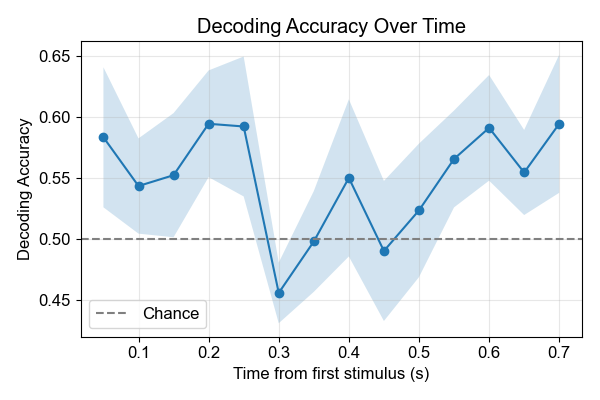

In [39]:
from sklearn.svm import SVC
# Define time windows to analyze (sliding windows)
window_size = 0.1  # 100ms windows
step_size = 0.05   # 50ms steps
start_times = np.arange(0, 1.5, step_size)  # Adjust range as needed

# Initialize arrays to store results for each time window
time_accuracies = []
time_accuracies_sem = []  # Changed to SEM

# For each time window
for start_time in start_times:
    # Get neural activity during this window
    stim_window = decoder_matrix.sel(time=slice(start_time, start_time + window_size))
    
    # Average activity across time bins to get one value per unit per trial
    X = stim_window.mean(dim='time').values
    y = (decoder_matrix.category == 'right').values.astype(int)
    
    # Skip windows with NaN values
    if np.isnan(X).any():
        continue
    
    # Initialize arrays for this time window
    window_accuracies = []
    
    # Cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train SVM
        svm = LinearSVC(penalty='l2', random_state=42, dual='auto')
        svm.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = svm.predict(X_test_scaled)
        window_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Store mean and SEM of accuracies for this time window
    time_accuracies.append(np.mean(window_accuracies))
    time_accuracies_sem.append(np.std(window_accuracies) / np.sqrt(len(window_accuracies)))  # Changed to SEM
    
# Convert to numpy arrays for plotting
valid_times = start_times[:len(time_accuracies)] + window_size/2
time_accuracies = np.array(time_accuracies)
time_accuracies_sem = np.array(time_accuracies_sem)  # Changed to SEM

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(valid_times, time_accuracies, '-o')
plt.fill_between(valid_times, 
                 time_accuracies - time_accuracies_sem,  # Changed to SEM
                 time_accuracies + time_accuracies_sem,  # Changed to SEM
                 alpha=0.2)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
plt.xlabel('Time from first stimulus (s)')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [63]:
decoder_matrix

<xarray.DataArray (trial: 96, time: 107, unit: 178)> Size: 15MB
array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
...
        ...,
        [  0.,   0., 100., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 100., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]])
Coordinates:
  * trial            (trial) int64 768B 760 43 14 617 744 ... 648 166 712 412 17
  * time             (time) float64 856B 0.0 0.01 0.02 0.03 ... 1.04 1.05 1.06
  * unit             (unit) int64 1kB 0 1 2 3 4 5 6 ... 172 173 174 175 176 177
    trial_outcome    (trial) int16 192B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    response_side    (trial) float64 768B 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    trial_rate       (trial) int64 768B 8 10 4 5 5 10 8 ... 20 19 18 14 14 18 18
    category         (trial) object 768B 'left' 'left' ... 'right' 'right'
    detected_events  (trial) int64 768B 8 10 4 5 5 10 8 ... 20 19 18 14 14 18 18
Attributes:
    bin_size:  0.01
    units:     spikes/second

/Users/gabriel/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM accuracy: 0.939 ± 0.029
RBF SVM accuracy: 0.969 ± 0.015


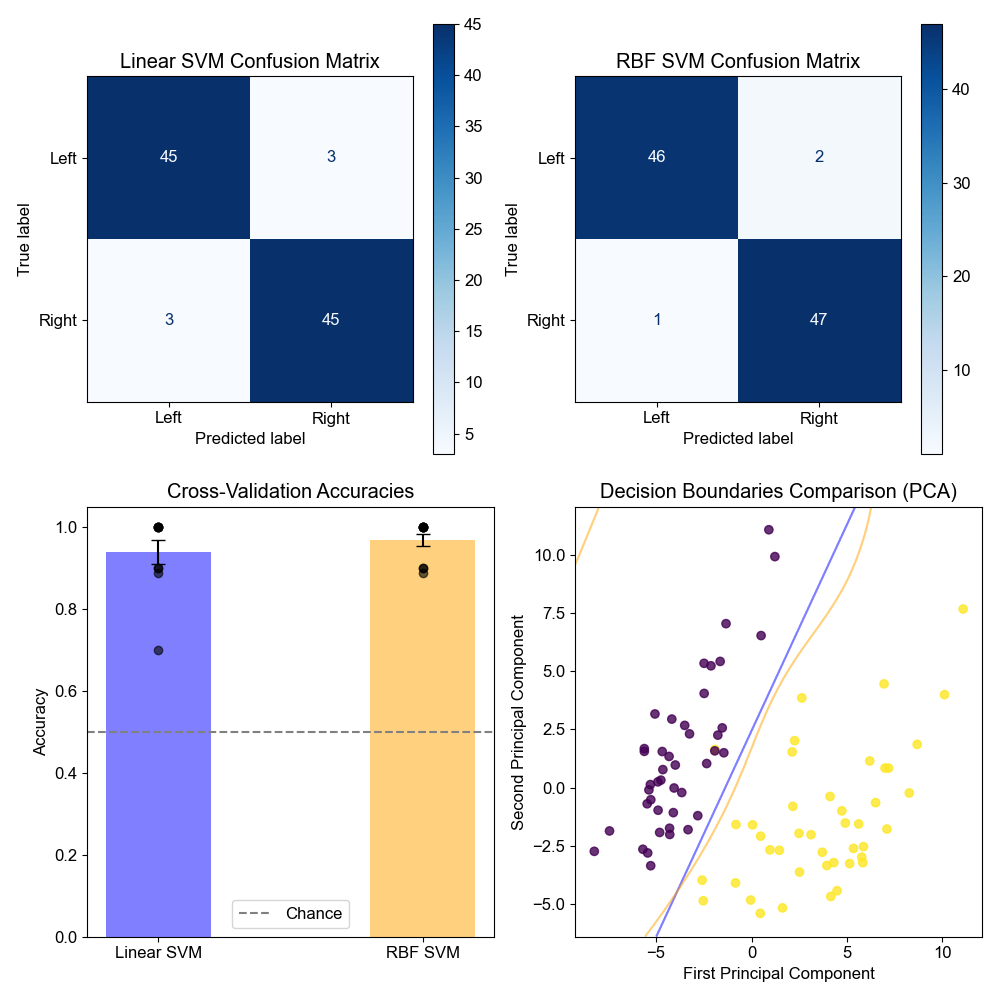

In [74]:
# Get neural activity during stimulus window
stim_window = decoder_matrix.sel(time=slice(0.6, 1))

# Average activity across time bins to get one value per unit per trial
X = stim_window.mean(dim='time').values

# Get trial categories (left vs right)
y = (decoder_matrix.response_side == 1).values.astype(int)

# Import classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# Initialize arrays to store results
linear_accuracies = []
rbf_accuracies = []
linear_predictions = []
rbf_predictions = []
true_labels = []

# Create stratified k-fold cross validation splits
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# For each fold
for train_idx, test_idx in skf.split(X, y):
    # Split data into train and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Linear SVM
    linear_svm = LinearSVC(penalty='l2', random_state=42, dual='auto')
    linear_svm.fit(X_train_scaled, y_train)
    
    # Train RBF SVM
    rbf_svm = SVC(kernel='rbf', random_state=42)
    rbf_svm.fit(X_train_scaled, y_train)
    
    # Make predictions
    linear_pred = linear_svm.predict(X_test_scaled)
    rbf_pred = rbf_svm.predict(X_test_scaled)
    
    # Store results
    linear_accuracies.append(accuracy_score(y_test, linear_pred))
    rbf_accuracies.append(accuracy_score(y_test, rbf_pred))
    linear_predictions.extend(linear_pred)
    rbf_predictions.extend(rbf_pred)
    true_labels.extend(y_test)  # Store true labels for each fold

# Print accuracies
print(f"Linear SVM accuracy: {np.mean(linear_accuracies):.3f} ± {np.std(linear_accuracies)/np.sqrt(len(linear_accuracies)):.3f}")
print(f"RBF SVM accuracy: {np.mean(rbf_accuracies):.3f} ± {np.std(rbf_accuracies)/np.sqrt(len(rbf_accuracies)):.3f}")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 1. Confusion Matrices
cm_linear = confusion_matrix(true_labels, linear_predictions)
cm_rbf = confusion_matrix(true_labels, rbf_predictions)

ConfusionMatrixDisplay(
    confusion_matrix=cm_linear,
    display_labels=['Left', 'Right']
).plot(ax=axes[0,0], cmap='Blues')
axes[0,0].set_title('Linear SVM Confusion Matrix')

ConfusionMatrixDisplay(
    confusion_matrix=cm_rbf,
    display_labels=['Left', 'Right']
).plot(ax=axes[0,1], cmap='Blues')
axes[0,1].set_title('RBF SVM Confusion Matrix')

# 2. Bar plot of accuracies with individual points
bar_positions = [0, 1]
bar_width = 0.4
means = [np.mean(linear_accuracies), np.mean(rbf_accuracies)]
sems = [np.std(linear_accuracies)/np.sqrt(len(linear_accuracies)), 
        np.std(rbf_accuracies)/np.sqrt(len(rbf_accuracies))]

# Plot bars
bars = axes[1,0].bar(bar_positions, means, bar_width, 
                    yerr=sems, capsize=5, alpha=0.5,
                    color=['blue', 'orange'])

# Plot individual points
for i, acc in enumerate([linear_accuracies, rbf_accuracies]):
    axes[1,0].scatter([i] * len(acc), acc, 
                     color='black', alpha=0.6, 
                     zorder=2)  # zorder ensures points are plotted on top

# Customize the plot
axes[1,0].set_xticks(bar_positions)
axes[1,0].set_xticklabels(['Linear SVM', 'RBF SVM'])
axes[1,0].axhline(y=0.5, color='gray', linestyle='--', label='Chance')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_title('Cross-Validation Accuracies')
axes[1,0].legend()

# 3. PCA visualization with both decision boundaries
# Get one fold of data
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Scale and PCA transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

# Create mesh grid
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Train both SVMs on 2D data
linear_svm_2d = LinearSVC(penalty='l2', random_state=42, dual='auto')
rbf_svm_2d = SVC(kernel='rbf', random_state=42)

linear_svm_2d.fit(X_train_2d, y_train)
rbf_svm_2d.fit(X_train_2d, y_train)

# Plot decision boundaries
Z_linear = linear_svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = rbf_svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])

Z_linear = Z_linear.reshape(xx.shape)
Z_rbf = Z_rbf.reshape(xx.shape)

axes[1,1].contour(xx, yy, Z_linear, colors='blue', alpha=0.5, levels=[0])
axes[1,1].contour(xx, yy, Z_rbf, colors='orange', alpha=0.5, levels=[0])

scatter = axes[1,1].scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.8)
axes[1,1].set_xlabel('First Principal Component')
axes[1,1].set_ylabel('Second Principal Component')
axes[1,1].set_title('Decision Boundaries Comparison (PCA)')

plt.tight_layout()
plt.show()